# Practical 1 : integrating single-cell and spatial analyses in python
In this practical, you will consecutively analyse single-cell (10X genomics chromium) and spatial transcriptomics (10X genomics Visium) from a pleural mesothelioma tumor.

We will focus on a single donor, patient 3B, a 80+ y.o. male without asbestos exposure on which 1 single-cell and 1 spatial sequencing were performed.

## Part II: spatial analyses and cell-cell communication
In the second part of the practical, you will explore spatial expression patterns, determine spatial domains and infer significant cell-cell interactions from single-cell and spatial datasets.

The data was already processed (see scripts in files/data/Practical1/S/scripts/), with QC and filtering of cells and features and normalization. You can find an example of basic spatial data processing in a scanpy tutorial: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html      
Spatial deconvolution with a scRNA-seq reference was already performed with cell2location method. This step is too computationally demanding to include in this practical, but you can find a tutorial on spatial deconvolution here: https://www.sc-best-practices.org/spatial/deconvolution.html

For the analysys steps we will mostly use the squidpy package. Similarly to the scanpy module, squidpy has submodules gr for graph analyses (e.g., computing nearest neighbors and graph metrics), pl for plotting functions, and tl for tools, as well as im for image analyses. See documentation (https://squidpy.readthedocs.io/en/stable/api.html) for further details on functions and arguments.

### Loading modules

In [1]:
import squidpy as sq
import scanpy as sc
import liana as li

/home/yuliya.lim/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/yuliya.lim/.local/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/yuliya.lim/.local/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

### Loading data  

Q1. Load the ST dataset (10X Visium sample from a pleural mesothelioma tumor). You may use scanpy to read the anndata object. 

In [ ]:
# load spatial data with cell-type deconvolution 
#file_path = r"Z:\Training-MG\files\data\Practical1\ST\2025\sample3B_visium_deconvoluted.h5ad"
file_inuvika = r"/data/Training-MG/files/data/Practical1/ST/2025/sample3B_visium_deconvoluted.h5ad"
adata_st = ### YOUR CODE HERE ###

### Overview of the data  

Q2. Explore the loaded anndata object. How many spots and features (genes) it contains? Can you access raw and log-normalised counts? Where the deconvolution results are stored?

In [128]:
### YOUR CODE HERE ###

Q3. Plot the QC metrics (number of genes expressed per spot, total number of counts per spot and the percentage of mitochondrial gene expression) for this dataset. You may use violin plot from scanpy. 

In [ ]:
#violin plots of QC metrics

sc.pl.violin(
    ### YOUR CODE HERE ###,
    jitter=0.4,
    multi_panel=True,
)


'\nsc.pl.violin(\n    ### YOUR CODE HERE ###,\n    jitter=0.4,\n    multi_panel=True,\n)\n'

Q4. Visualize clusters (maybe not), number of genes expressed per spot and total number of counts per spot on a spatial plot using sq.pl.spatial_scatter(). Note the heterogeneity in gene expression over the Visium sample.

In [ ]:
adata_st.obs["cluster"] = adata_st.obs["cluster"].astype("category")

sq.pl.spatial_scatter(___ YOUR CODE HERE ___, color=___ YOUR CODE HERE ___, figsize=(7, 7)) 

Q5. Visualize spatial expression of some of the highly variable genes. Do they present any spatial pattern?

In [130]:
### YOUR CODE HERE ###

Q6. Visualize the proportions of some cell types on the spatial slide (tumor, stromal, mesothelial, some immune cell type). Do they occupy different locations on the spatial slide? 

In [131]:
### YOUR CODE HERE ###

### Identifying spatial domains  

#### 1. Compute spatial proximity and gene expression proximity graphs. 

Q7. Run the function neighbors() from scanpy and the function spatial_neighbors() from squidpy to create graphs based on spot expression similarity and spatial proximity. Save them as distinct variables. 



In [ ]:
# compute expression proximity graph
sc.pp.neighbors(### YOUR CODE HERE ###)
nn_graph_genes = ### YOUR CODE HERE ###

# compute spatial proximity graph
sq.gr.spatial_neighbors(### YOUR CODE HERE ###)
nn_graph_space = ### YOUR CODE HERE ###


Q8: Identify domains with squidpy. Combine the two graphs, perform leiden clustering on the joint graph (sc.tl.leiden()), and plot the results using the spatial_scatter function from squidpy. 
Try changing the weight of the expression and spatial KNN graphs to see how they influence the results.

In [ ]:
alpha = 0.4

joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space  # weighed sum of the two neigborhood graphs

sc.tl.leiden(___ YOUR CODE HERE ___, adjacency=___ YOUR CODE HERE ___, key_added="squidpy_domains")  

# plot squidpy spatial domains
### YOUR CODE HERE ###

In [62]:
#adata_st.uns.pop('squidpy_domains_colors')  #run if you want to clean squidpy_domains

Q9. Compare the inferred spatial domains with spatial deconvolution results (cell-type proportions). Do you notice any common patterns?

In [140]:
### YOUR CODE HERE ###

### Identifying spatially variable genes (SVGs)

Q10. Identify spatially variable genes using Moran's I statistic using graph module of squidpy: sq.gr.spatial_autocorr(). We will restrain the analysis to the set of highly variable genes.

In [ ]:
# subset HVG 
HVG_names = adata_st[:,adata_st.var.highly_variable].var_names

sq.gr.spatial_autocorr(### YOUR CODE HERE ###, genes=HVG_names)

Q11. Print the results and plot spatial expression of the top SVGs. Compare with the top HVGs. 

In [141]:
### YOUR CODE HERE ###

Are they expressed in the same area? If so, probably you computed the Moran's I on the raw counts, and it just highlighed the area with the highest expression (see Question 3).  
It is recommended to use normalized counts to find the SVGs. You may need to recompute the Moran's I on the log-transformed data (stored in .layers) 

### Neighborhood analysis  

After identification of spatial domains we can quantify the spatial enrichment of the obtained clusters.  

Neighborhood enrichment quantifies how often two clusters occur near each other in space.
If cells or spots from one cluster are frequently located next to those from another cluster, the pair receives a high enrichment score, indicating spatial enrichment.
On the other hand, if the two clusters rarely appear as neighbors, they tend to be spatially separated — the enrichment score is low, indicating spatial depletion.

Calculating neighborhood enrichment using `1` core(s)


100%|██████████| 1000/1000 [00:15<00:00, 63.02/s]


Adding `adata.uns['squidpy_domains_nhood_enrichment']`
Finish (0:00:16)


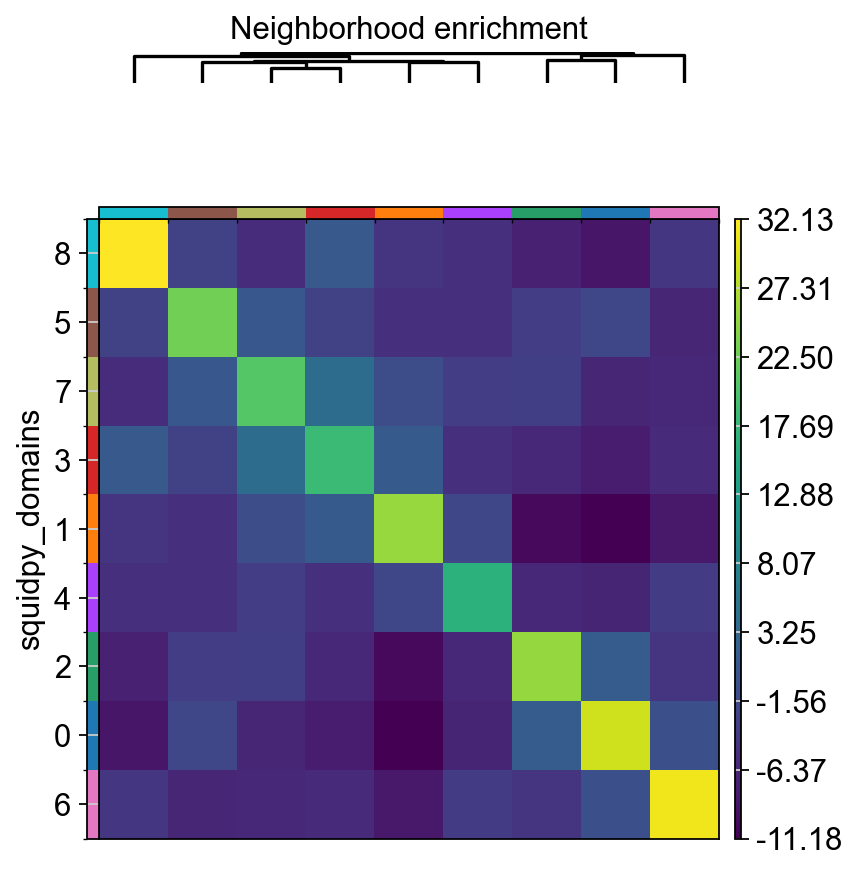

In [68]:
#sq.gr.spatial_neighbors(adata_st)
sq.gr.nhood_enrichment(adata_st, cluster_key="squidpy_domains")
sq.pl.nhood_enrichment(adata_st, cluster_key="squidpy_domains", method="average", figsize=(5, 5))


### Cell-cell interaction inference

In this section, we will infer cell-cell interactions between cell types and spatial regions. We will start by using LIANA+ framework that combines various inference methods and LR ressources.  
See documentation and tutorials at LIANA+ web page: https://liana-py.readthedocs.io/en/latest/api.html 

#### 1. CCI inference from annotated scRNA-seq data (dissociated cells). 

Q12. Load the annotated single-cell data from the previous TP.

In [ ]:
dir_sc = r"Z:\Training-MG\files\data\Practical1\scRNAseq\2025\annotated\sample3B_annotation_level2.h5ad"

adata_sc = ### YOUR CODE HERE ###

Cell–cell signalling is inferred between pairs of cell groups, defined as source and target populations of cells.  
To perform this analysis, you have to provide annotations that assign each cell to one of these groups.  In single-cell datasets, these groups typically correspond to the identified cell types.

Q13. Explore the loaded data. How many clls and features it has? Check the cell type annotations ("annotation_level2" column).

In [142]:
### YOUR CODE HERE ###

Q14. Run rank_aggregated method from li.mt on single-cell log-normalised counts, with "consensus" resource and cell-type annotations.

In [72]:
# methods available in liana
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


In [ ]:
# rank aggregate

li.mt.rank_aggregate(### YOUR CODE HERE ###,
                     groupby = ### YOUR CODE HERE ###,
                     resource_name =  ### YOUR CODE HERE ###,
                     layer = ### YOUR CODE HERE ###,
                     use_raw = False,
                     expr_prop=0.1,
                     verbose=True)

Q15. Print the obtained results. Sort the values by the magnitude_rank column (rank by the strength of the signal).

In [144]:
### YOUR CODE HERE ###

Q16. Make a dotplot of the aggregated interaction scores (magnitude_rank). You can provide specific cell types as source and target groups.

In [ ]:
li.pl.dotplot(adata = ### YOUR CODE HERE ###, 
              colour=### YOUR CODE HERE ###,
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=### YOUR CODE HERE ###,
              target_labels=### YOUR CODE HERE ###,
              top_n=### YOUR CODE HERE ###,   # number of top interactions to visualize
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

Q17. Plot spatial expression of some ligand-receptor pairs with high lrscore. Are they spatially co-localised?

In [149]:
### YOUR CODE HERE ###

Q18 (optional). Plot a cell-cell interaction network with cell types in the nodes and aggregated score to compute the weights of the edges.

In [ ]:
li.pl.circle_plot(adata_sc,
                  groupby=### YOUR CODE HERE ###,
                  score_key=### YOUR CODE HERE ###,
                  inverse_score=True,
                  source_labels=[### YOUR CODE HERE ###],
                  filter_fun=lambda x: x['specificity_rank'] <= 0.05,
                  pivot_mode='mean',  # or "count" to weight by the number of interactions
                  figure_size=(10, 10),
                  )